In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from pathlib import Path
from tqdm.notebook import tqdm
from IPython import display
from time import time

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda')

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14,5)
plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['axes.grid'] = False

In [3]:
import utils
import models

from pystoi import stoi
from pesq import pesq

In [4]:
SAMPLE_RATE = 16000

def listen(wave_or_path, sr=SAMPLE_RATE):
    '''Удобство для прослушивания в ноутбуке. Можно подавать как массив амлитуд, так и путь к файлу.'''
    if isinstance(wave_or_path, (np.ndarray, torch.Tensor)):
        wave = wave_or_path
    elif isinstance(wave_or_path, (str, Path)):
        wave, _ = librosa.load(wave_or_path, sr=sr)
    else:
        raise TypeError('wave_or_path must be one of (np.array, torch.Tensor, str, pathlib.Path)')
    return display.Audio(wave, rate=sr)

**How data was created:**

In [ ]:
DATA_PATH = 'path/to/TIMIT'

p = Path(DATA_PATH+'/TRAIN')
train_files = np.array(list(p.rglob('*.wav')))

p = Path(DATA_PATH+'/TEST')
test_files = np.array(list(p.rglob('*.wav')))

len(train_files), len(test_files)

In [ ]:
np.random.seed(0)
train_files_300 = train_files[np.random.choice(len(train_files), 300, replace=False)]
test_files_100 = test_files[np.random.choice(len(test_files), 100, replace=False)]

In [ ]:
noise_files_train = np.array(list(Path('data/noise_fx/train/').glob('*.wav')))
noise_files_test = np.array(list(Path('data/noise_fx/test/').glob('*.wav')))

In [ ]:
utils.create_data('data/train/', train_files_300, noise_files_train, SAMPLE_RATE, snr_levels=(-8,-4,0,4,8), max_len=300, n_fft=512)

In [ ]:
utils.create_data('data/test/', test_files_100, noise_files_test, SAMPLE_RATE, snr_levels=(-12,-6,0,6,12), max_len=300, n_fft=512)

## Dataset

In [6]:
train_dataset = utils.FileSpecDataset('data/train/')
test_dataset = utils.FileSpecDataset('data/test/')

train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

**Преподсчет Q(clean, noisy) на тесте (baseline):**

In [ ]:
import joblib
Q = models.MetricSTOI(SAMPLE_RATE)
p = joblib.Parallel(4)
scores = p(joblib.delayed(Q)([clean],[noisy]) for i,(clean,noisy) in enumerate(tqdm(iter_waves(test_dataset), total=len(test_dataset))))

In [ ]:
scores_stoi_noisy_test = torch.cat(scores)
torch.save(scores_stoi_noisy_test, 'output/scores_stoi_noisy_test.pt')

In [7]:
scores_stoi_noisy_test = torch.load('output/scores_stoi_noisy_test.pt')
scores_stoi_noisy_test.mean()

tensor(0.7181)

## Models

In [82]:
torch.manual_seed(0)
G = models.Generator_Sigmoid_LSTM().to(device)
D = models.Discriminator_Stride2_SN().to(device)
Q = models.MetricSTOI(SAMPLE_RATE).to(device)

D.apply(models.xavier_init)

optimizer_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.9, 0.999))

In [83]:
net_name = 'metricGAN_alldata_1_mul_sigm_sn_truenorm_stride'

## Train

In [ ]:
G.train()
D.train()

target_value = 1.0  # parameter 's' according to Eq.(5) in paper
lamb = 0.01
num_epochs = 7
losses = []
dq_hist = []
scheduler = None

start_time = time()

i = 0
for epoch in range(num_epochs):
    for spec_noisy, spec_clean, phase_noisy, phase_clean, wave_noisy, wave_clean in train_loader:
        
        batch_size = spec_noisy.shape[0]
        target_labels = torch.full((batch_size,), target_value, device=device)
        ones_labels = torch.ones(batch_size, device=device)
        
        # make normalization as authors
        spec_noisy_amplitude, spec_noisy_amplitude_normalized = utils.process_batch_as_authors(spec_noisy)
        spec_noisy_amplitude, spec_noisy_amplitude_normalized = spec_noisy_amplitude.to(device), spec_noisy_amplitude_normalized.to(device)        
        spec_clean_amplitude, spec_clean_amplitude_normalized = utils.process_batch_as_authors(spec_clean)
        spec_clean_amplitude, spec_clean_amplitude_normalized = spec_clean_amplitude.to(device), spec_clean_amplitude_normalized.to(device)        
        spec_noisy, spec_clean = spec_noisy.to(device), spec_clean.to(device)

        # FORWARD pass, generating...
        G.requires_grad_(True)
        spec_enhanced, mask = G(spec_noisy_amplitude, spec_noisy_amplitude_normalized)
        with torch.no_grad():
            wave_enhanced = [utils.spec_to_wave_amplitude(sp, phase=ph) for sp, ph in zip(spec_enhanced.detach().cpu(), phase_noisy)]
            q_score = Q(wave_clean, wave_enhanced).to(torch.float32)

        # TRAIN Generator
        G.requires_grad_(True)
        D.requires_grad_(False)
        optimizer_G.zero_grad()
        loss_G = lamb * F.mse_loss(D(spec_enhanced, spec_clean_amplitude).flatten(), target_labels) \
                 + F.l1_loss(spec_enhanced.flatten(), spec_clean_amplitude.flatten())
        loss_G.backward()
        optimizer_G.step()

        # TRAIN Discriminator
        G.requires_grad_(False)
        D.requires_grad_(True)
        optimizer_D.zero_grad()
        loss_D_real = F.mse_loss(D(spec_clean_amplitude, spec_clean_amplitude).flatten(), ones_labels)
        loss_D_fake = F.mse_loss(D(spec_enhanced.detach(), spec_clean_amplitude).flatten(), q_score)
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        losses.append([loss_G.item(), loss_D.item()])
        
        if scheduler: scheduler.step()

        if i % 10 == 0:
            torch.save({'G':G.state_dict(), 'D':D.state_dict()}, net_name+'_checkpoint.pth')
#             clear_output(True)
            m = int(time() - start_time)//60
            s = int(time() - start_time)%60
            q_score_noisy = Q(wave_clean, wave_noisy)
            dq = (q_score-q_score_noisy).mean().item()
            dq_hist.append(dq)
            print(f'{epoch}-{i}, {losses[-1][0]:.4f} {losses[-1][1]:.4f}, dq: {dq:.4f} ({m:>02}:{s:>02})')
        i += 1

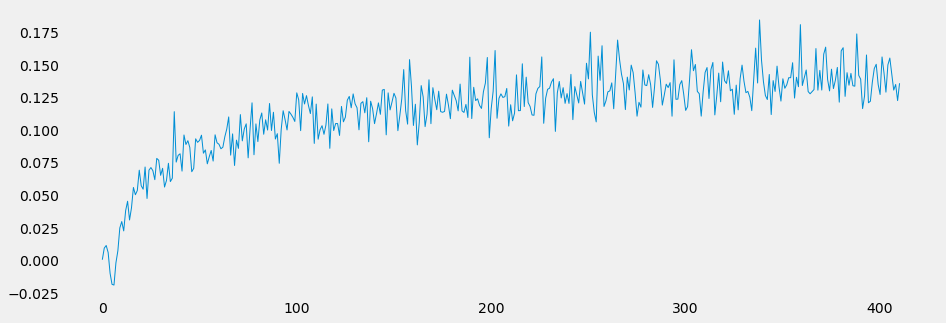

In [35]:
plt.plot(dq_hist)

In [27]:
# torch.save(dq_hist, 'dq_hist_'+net_name+'_e7')
# torch.save(losses, 'losses_'+net_name+'_e7')

In [19]:
# torch.save({'G':G.state_dict(), 'D':D.state_dict()}, net_name+'_e7.pth')

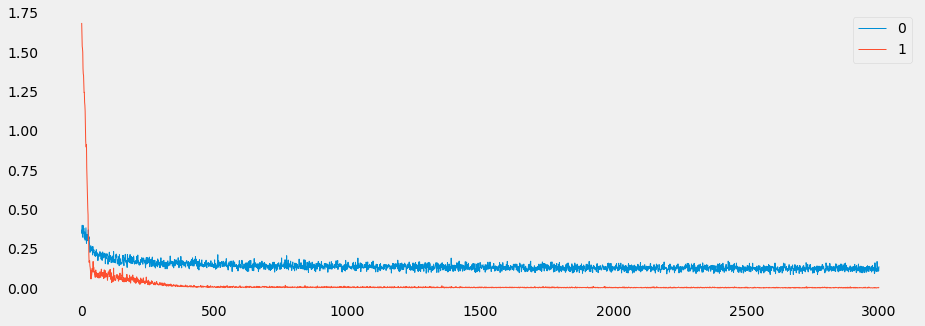

In [20]:
import pandas as pd
pd.DataFrame(losses).plot()

In [86]:
loaded = torch.load('saved_models/kaggle_metricGAN_alldata_1_mul_sigm_sn_truenorm_stride_e7_0_7610.pth')
G.load_state_dict(loaded['G'])
D.load_state_dict(loaded['D'])

<All keys matched successfully>

## Evaluate

In [87]:
G.eval()
D.eval()

scores_enh = []
masks = []
waves_enh = []

for spec_noisy, spec_clean, phase_noisy, phase_clean, wave_noisy, wave_clean in tqdm(test_loader):

    spec_noisy_amplitude, spec_noisy_amplitude_normalized = utils.process_batch_as_authors(spec_noisy)
    spec_noisy_amplitude, spec_noisy_amplitude_normalized = spec_noisy_amplitude.to(device), spec_noisy_amplitude_normalized.to(device)        
        
    batch_size = spec_noisy.shape[0]
    
    # FORWARD pass
    with torch.no_grad():
        spec_enhanced, mask = G(spec_noisy_amplitude, spec_noisy_amplitude_normalized)
        wave_enhanced = [utils.spec_to_wave_amplitude(sp, phase=ph) for sp, ph in zip(spec_enhanced.detach().cpu(), phase_noisy)]
        q_score = Q(wave_clean, wave_enhanced)
        
    masks.append(mask)
    scores_enh.append(q_score)
    waves_enh += wave_enhanced
    
    
masks = torch.cat(masks)
scores_enh = torch.cat(scores_enh)
waves_enh = torch.tensor(waves_enh)

In [169]:
print(scores_enh.mean())

tensor(0.7610, device='cuda:0')


In [170]:
print(scores_stoi_noisy_test.mean())

tensor(0.7181)


**Посмотрим на каких сэмплах из теста модель плохо работает, а на каких хорошо:**

<BarContainer object of 2000 artists>

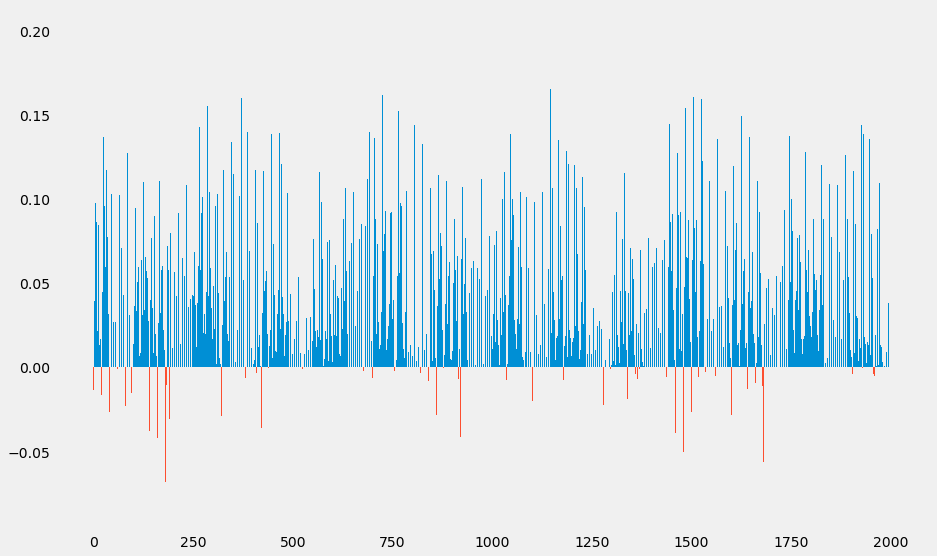

In [91]:
d = scores_enh.cpu() - scores_stoi_noisy_test
plt.figure(figsize=(14,9))
plt.bar(range(2000), torch.clamp_max(d, 0.0), color='C1')
plt.bar(range(2000), torch.clamp_min(d, 0.0))

### Save Results

In [173]:
listen(waves_enh[831])

In [95]:
listen(test_dataset[831][-2])

In [174]:
librosa.output.write_wav('wav_generated/alldata_stride2_STOI_831.wav', np.array(waves_enh[831]), sr=SAMPLE_RATE)
# librosa.output.write_wav('wav_generated/noisy_5.wav', np.array(test_dataset[5][-2]), sr=SAMPLE_RATE)
# librosa.output.write_wav('wav_generated/clean_5.wav', np.array(test_dataset[5][-1]), sr=SAMPLE_RATE)

In [155]:
import pandas as pd


vals = np.array([[2.375, 0.919, 2.967, 0.939],
[1.963, 0.831, 2.616, 0.885],
[1.589, 0.709, 2.200, 0.802],
[1.242, 0.576, 1.711, 0.679],
[0.971, 0.473, 1.169, 0.533]])

mic = pd.MultiIndex.from_tuples([('Noisy', 'PESQ'), ('Noisy', 'STOI'), ('MetricGAN (P)', 'PESQ'),  ('MetricGAN (S)', 'STOI')])
df = pd.DataFrame(vals, index=[12,6,0,-6,-12], columns=mic)
df.index.name = 'SNR, dB'
s = df.mean()
s.name = 'Avg.'

df = df.append(s, ignore_index=False)
df

Noisy         MetricGAN (P) MetricGAN (S)
          PESQ    STOI          PESQ          STOI
SNR, dB                                           
12       2.375  0.9190        2.9670        0.9390
6        1.963  0.8310        2.6160        0.8850
0        1.589  0.7090        2.2000        0.8020
-6       1.242  0.5760        1.7110        0.6790
-12      0.971  0.4730        1.1690        0.5330
Avg.     1.628  0.7016        2.1326        0.7676

In [157]:
torch.load('results_authors2.df')

Noisy         MetricGAN (P) MetricGAN (S)
          PESQ    STOI          PESQ          STOI
SNR, dB                                           
12       2.375  0.9190        2.9670        0.9390
6        1.963  0.8310        2.6160        0.8850
0        1.589  0.7090        2.2000        0.8020
-6       1.242  0.5760        1.7110        0.6790
-12      0.971  0.4730        1.1690        0.5330
Avg.     1.628  0.7016        2.1326        0.7676

In [101]:
import itertools
import pandas as pd

table = {'speech_idx':[], 'noise_type':[], 'snr':[], 'score_noisy':[], 'score_enhanced':[]}
for i, (speech_idx, noise_type, snr) in enumerate(itertools.product(range(100), ('engine', 'white', 'street', 'baby_cry'), range(-12,18,6))):
    score_noisy = scores_stoi_noisy_test[i].item()
    score_enhanced = scores_enh[i].item()
    table['speech_idx'].append(speech_idx)
    table['noise_type'].append(noise_type)
    table['snr'].append(snr)
    table['score_noisy'].append(score_noisy)
    table['score_enhanced'].append(score_enhanced)
table = pd.DataFrame(table)

In [104]:
table['score_delta'] = table['score_enhanced'] - table['score_noisy']

In [141]:
pivot_table = table.pivot_table(values=['score_noisy', 'score_enhanced'], index=['snr'])
s_enh = pivot_table.sort_index(axis=0, ascending=False)['score_enhanced']
s_enh['Avg.'] = s_enh.mean()
s_noisy = pivot_table.sort_index(axis=0, ascending=False)['score_noisy']
s_noisy['Avg.'] = s_noisy.mean()

In [158]:
df_stoi = df.copy()

In [159]:
df_stoi[:] = 0.0

In [165]:
df_stoi['Noisy','STOI'] = s_noisy
df_stoi['MetricGAN (S)','STOI'] = s_enh

In [166]:
df_stoi

Noisy         MetricGAN (P) MetricGAN (S)
         PESQ    STOI          PESQ          STOI
SNR, dB                                          
12        0.0  0.9233           0.0        0.9417
6         0.0  0.8451           0.0        0.8835
0         0.0  0.7340           0.0        0.7891
-6        0.0  0.6055           0.0        0.6646
-12       0.0  0.4826           0.0        0.5260
Avg.      0.0  0.7181           0.0        0.7610

In [167]:
torch.save(df_stoi, 'results_my.df')